In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import copy
import os


In [54]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = 'cpu'
print(device)

mps


In [76]:
data_transform =transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# load datasets
DATA_PATH = './data/mnist'

train = datasets.MNIST(DATA_PATH, train=True, download=True, transform=data_transform)
val = datasets.MNIST(DATA_PATH, train=False, download=True, transform=data_transform)

x_train, y_train = train.data, train.targets
x_val, y_val = val.data, val.targets

# dimension : B * H * W
print(x_train.shape, x_val.shape)

# set dimension as B * C * H * W
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)
if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)
print(x_train.shape, x_val.shape)

# create dataloader
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

torch.manual_seed(0)


torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])


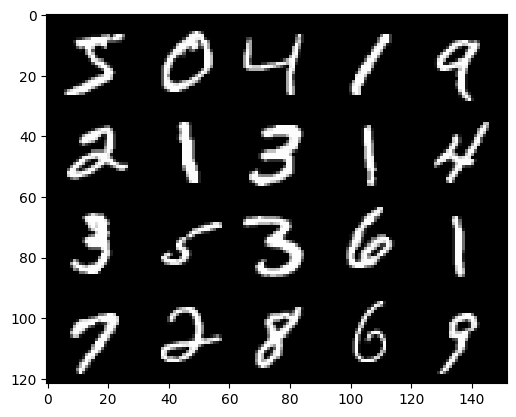

In [77]:
# show sample images
def show_img(img):
    npimg = img.numpy()
    # in torch, image is (channel, width, height)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

x_grid = utils.make_grid(x_train[:20], nrow=5, padding=2)

show_img(x_grid)

In [78]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16,  120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
model = LeNet_5().to(device)
print(next(model.parameters()).device)
model.eval()

mps:0


LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [79]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_lr (optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# CosineAnnealingLR : learning rate osicletes between initial lr and eta_min
# T_max : maximum number of iterations
lr_scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.001)


In [80]:
# calculate accuracy per batch
def get_accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# calculate loss per batch
def loss_batch(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    acc = get_accuracy(output, target)
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), acc

# calculate performance loss, accuracy per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, optimizer=None):
    running_loss = 0
    running_acc = 0
    len_data = float(len(dataset_dl.dataset))

    for xb, yb in dataset_dl:
        xb = xb.type(torch.float).to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, acc_b = loss_batch(loss_func, output, yb, optimizer)
        running_loss += loss_b

        if acc_b:
            running_acc += acc_b
        
        if sanity_check: # if sannity_check is True, only one batch is processed
            break

    loss = running_loss / len_data
    acc = running_acc / len_data
    return loss, acc


In [81]:
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': []
    }

    acc_history = {
        'train': [],
        'val': []
    }

    best_model_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_acc = loss_epoch(model, loss_func, train_dl, sanity_check, optimizer)
        loss_history['train'].append(train_loss)
        acc_history['train'].append(train_acc)

        model.eval()
        with torch.no_grad():
            val_loss, val_acc = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history['val'].append(val_loss)
            acc_history['val'].append(val_acc)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step()

        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' % (train_loss, val_loss, val_acc*100))
        print('-'*15)

        if epoch % 5 == 0:
            model.load_state_dict(best_model_weights)

    return model, loss_history, acc_history

In [82]:
os.makedirs('./models', exist_ok=True)

params_train = {
    'num_epochs': 10,
    'optimizer': optimizer,
    'loss_func': criterion,
    'train_dl': train_loader,
    'val_dl': val_loader,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': './models/weights.pt'
}

model, loss_hist, acc_hist = train_val(model, params_train)

Epoch 0/9, current lr = 0.001
Copied best model weights!
train loss: 1.569753, dev loss: 1.513244, accuracy: 95.29
---------------
Epoch 1/9, current lr = 0.001
Copied best model weights!
train loss: 1.501782, dev loss: 1.496142, accuracy: 96.66
---------------
Epoch 2/9, current lr = 0.001
Copied best model weights!
train loss: 1.490661, dev loss: 1.488827, accuracy: 97.25
---------------
Epoch 3/9, current lr = 0.001
Copied best model weights!
train loss: 1.484740, dev loss: 1.485705, accuracy: 97.55
---------------
Epoch 4/9, current lr = 0.001
Copied best model weights!
train loss: 1.481401, dev loss: 1.483994, accuracy: 97.84
---------------
Epoch 5/9, current lr = 0.001
train loss: 1.479354, dev loss: 1.484716, accuracy: 97.65
---------------
Epoch 6/9, current lr = 0.001
Copied best model weights!
train loss: 1.479748, dev loss: 1.482802, accuracy: 97.88
---------------
Epoch 7/9, current lr = 0.001
Copied best model weights!
train loss: 1.477203, dev loss: 1.479626, accuracy: 9

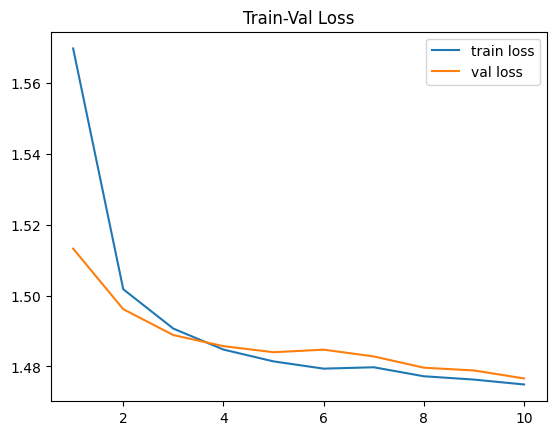

In [83]:
num_epochs = params_train['num_epochs']

plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train loss')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val loss')
plt.legend()
plt.show()

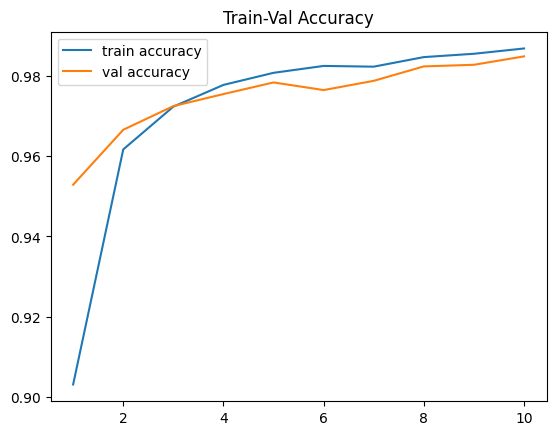

In [84]:
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['train'], label='train accuracy')
plt.plot(range(1, num_epochs+1), acc_hist['val'], label='val accuracy')
plt.legend()
plt.show()